In [47]:
#import pandas and sqlite
import pandas as pd
import sqlite3 as sl

In [48]:
#connecct to database object
conn = sl.connect('NYT_covid.db')
c = conn.cursor()

In [49]:
#confirm tables present
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print (name[0])

deaths
mask_use
us
regions
election
states
counties


In [50]:
#update counties table with most recent data
counties = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv', index_col=0, encoding='latin-1')

c.execute('DROP TABLE IF EXISTS counties')
c.execute('CREATE TABLE counties (date datetime, county str, state str, fips str, cases int, deaths int, confirmed_cases int, confirmed_deaths int, probable_cases int, probable_deaths int)')
conn.commit()

counties.to_sql('counties',conn, if_exists='replace')

In [51]:
df = pd.read_sql('''SELECT * FROM counties WHERE state = 'Illinois' AND county = 'Cook' ORDER by date asc''',conn)
df

,date,county,state,fips,cases,deaths
0,2020-01-24,Cook,Illinois,17031.0,1,0.0
1,2020-01-25,Cook,Illinois,17031.0,1,0.0
2,2020-01-26,Cook,Illinois,17031.0,1,0.0
3,2020-01-27,Cook,Illinois,17031.0,1,0.0
4,2020-01-28,Cook,Illinois,17031.0,1,0.0
...,...,...,...,...,...,...
315,2020-12-04,Cook,Illinois,17031.0,322122,6852.0
316,2020-12-05,Cook,Illinois,17031.0,325813,6922.0
317,2020-12-06,Cook,Illinois,17031.0,329003,6951.0
318,2020-12-07,Cook,Illinois,17031.0,332693,7018.0


In [52]:
df = pd.read_sql('''SELECT date, county, state, cases as 'Total_cases_to_date'
                    FROM counties 
                    WHERE state = 'Illinois'
                    AND county = 'Cook'
                    ''',conn)
df

,date,county,state,Total_cases_to_date
0,2020-01-24,Cook,Illinois,1
1,2020-01-25,Cook,Illinois,1
2,2020-01-26,Cook,Illinois,1
3,2020-01-27,Cook,Illinois,1
4,2020-01-28,Cook,Illinois,1
...,...,...,...,...
315,2020-12-04,Cook,Illinois,322122
316,2020-12-05,Cook,Illinois,325813
317,2020-12-06,Cook,Illinois,329003
318,2020-12-07,Cook,Illinois,332693


In [53]:
#we are going to explore LAG.  LAG is a window funcgtion that allows you to use values from previous rows.  
#By default, the offset is 1 (meaning the previous row is used)

df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    WHERE state = 'Illinois'
                    AND county = 'Cook'
                    ''',conn)
df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-01-24,Illinois,Cook,NaN,1,NaN,0.0
1,2020-01-25,Illinois,Cook,0.0,1,0.0,0.0
2,2020-01-26,Illinois,Cook,0.0,1,0.0,0.0
3,2020-01-27,Illinois,Cook,0.0,1,0.0,0.0
4,2020-01-28,Illinois,Cook,0.0,1,0.0,0.0
...,...,...,...,...,...,...,...
315,2020-12-04,Illinois,Cook,3798.0,322122,29.0,6852.0
316,2020-12-05,Illinois,Cook,3691.0,325813,70.0,6922.0
317,2020-12-06,Illinois,Cook,3190.0,329003,29.0,6951.0
318,2020-12-07,Illinois,Cook,3690.0,332693,67.0,7018.0


In [54]:
# COMBINING WITH PARTITION BY ALLOWS US TO GROUP ALL THE COUNTIES TOGETHER

df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY county ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY county ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    WHERE state = 'Illinois'
                    ''',conn)
df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-03-20,Illinois,Adams,NaN,1,NaN,0.0
1,2020-03-21,Illinois,Adams,0.0,1,0.0,0.0
2,2020-03-22,Illinois,Adams,0.0,1,0.0,0.0
3,2020-03-23,Illinois,Adams,0.0,1,0.0,0.0
4,2020-03-24,Illinois,Adams,0.0,1,0.0,0.0
...,...,...,...,...,...,...,...
25885,2020-12-04,Illinois,Woodford,36.0,1969,0.0,31.0
25886,2020-12-05,Illinois,Woodford,42.0,2011,0.0,31.0
25887,2020-12-06,Illinois,Woodford,22.0,2033,0.0,31.0
25888,2020-12-07,Illinois,Woodford,56.0,2089,1.0,32.0


In [55]:
#using different partitioning gives different results.  I am going to use fips to get this for all states/counties

df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county''',conn)
df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-03-24,Alabama,Autauga,NaN,1,NaN,0.0
1,2020-03-25,Alabama,Autauga,3.0,4,0.0,0.0
2,2020-03-26,Alabama,Autauga,2.0,6,0.0,0.0
3,2020-03-27,Alabama,Autauga,0.0,6,0.0,0.0
4,2020-03-28,Alabama,Autauga,0.0,6,0.0,0.0
...,...,...,...,...,...,...,...
810168,2020-12-04,Wyoming,Weston,0.0,419,0.0,2.0
810169,2020-12-05,Wyoming,Weston,0.0,419,0.0,2.0
810170,2020-12-06,Wyoming,Weston,1.0,420,0.0,2.0
810171,2020-12-07,Wyoming,Weston,2.0,422,0.0,2.0


In [56]:
df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county''',conn)

df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-03-24,Alabama,Autauga,NaN,1,NaN,0.0
1,2020-03-25,Alabama,Autauga,3.0,4,0.0,0.0
2,2020-03-26,Alabama,Autauga,2.0,6,0.0,0.0
3,2020-03-27,Alabama,Autauga,0.0,6,0.0,0.0
4,2020-03-28,Alabama,Autauga,0.0,6,0.0,0.0
...,...,...,...,...,...,...,...
810168,2020-12-04,Wyoming,Weston,0.0,419,0.0,2.0
810169,2020-12-05,Wyoming,Weston,0.0,419,0.0,2.0
810170,2020-12-06,Wyoming,Weston,1.0,420,0.0,2.0
810171,2020-12-07,Wyoming,Weston,2.0,422,0.0,2.0


In [57]:
#Now we will add in some rolling averages for new cases and new deaths, we have to use a cte to do this 

df = pd.read_sql('''WITH cte as (SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county)
                    
                    SELECT date, state, county, new_cases, cumulative_cases,
                    AVG(new_cases) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_new',
                    new_deaths, cumulative_deaths,
                    AVG(new_deaths) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_death'
                    FROM cte
                    ORDER BY state, county, date
                    ''',conn)
df

,date,state,county,new_cases,cumulative_cases,7-day_avg_new,new_deaths,cumulative_deaths,7-day_avg_death
0,2020-03-24,Alabama,Autauga,NaN,1,NaN,NaN,0.0,NaN
1,2020-03-25,Alabama,Autauga,3.0,4,3.000000,0.0,0.0,0.000000
2,2020-03-26,Alabama,Autauga,2.0,6,2.500000,0.0,0.0,0.000000
3,2020-03-27,Alabama,Autauga,0.0,6,1.666667,0.0,0.0,0.000000
4,2020-03-28,Alabama,Autauga,0.0,6,1.250000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
810168,2020-12-04,Wyoming,Weston,0.0,419,3.285714,0.0,2.0,0.142857
810169,2020-12-05,Wyoming,Weston,0.0,419,3.285714,0.0,2.0,0.142857
810170,2020-12-06,Wyoming,Weston,1.0,420,3.428571,0.0,2.0,0.142857
810171,2020-12-07,Wyoming,Weston,2.0,422,3.571429,0.0,2.0,0.142857


In [58]:
cook = pd.read_sql('''WITH cte as (SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county)
                    
                    SELECT date, state, county, new_cases, cumulative_cases,
                    AVG(new_cases) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_new',
                    new_deaths, cumulative_deaths,
                    AVG(new_deaths) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_death'
                    FROM cte
                    WHERE state = 'Illinois' and county = 'Cook'
                    ORDER BY date''',conn)
cook

,date,state,county,new_cases,cumulative_cases,7-day_avg_new,new_deaths,cumulative_deaths,7-day_avg_death
0,2020-01-24,Illinois,Cook,NaN,1,NaN,NaN,0.0,NaN
1,2020-01-25,Illinois,Cook,0.0,1,0.000000,0.0,0.0,0.000000
2,2020-01-26,Illinois,Cook,0.0,1,0.000000,0.0,0.0,0.000000
3,2020-01-27,Illinois,Cook,0.0,1,0.000000,0.0,0.0,0.000000
4,2020-01-28,Illinois,Cook,0.0,1,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
315,2020-12-04,Illinois,Cook,3798.0,322122,3321.714286,29.0,6852.0,53.714286
316,2020-12-05,Illinois,Cook,3691.0,325813,3461.571429,70.0,6922.0,50.571429
317,2020-12-06,Illinois,Cook,3190.0,329003,3540.428571,29.0,6951.0,50.857143
318,2020-12-07,Illinois,Cook,3690.0,332693,3760.571429,67.0,7018.0,49.857143


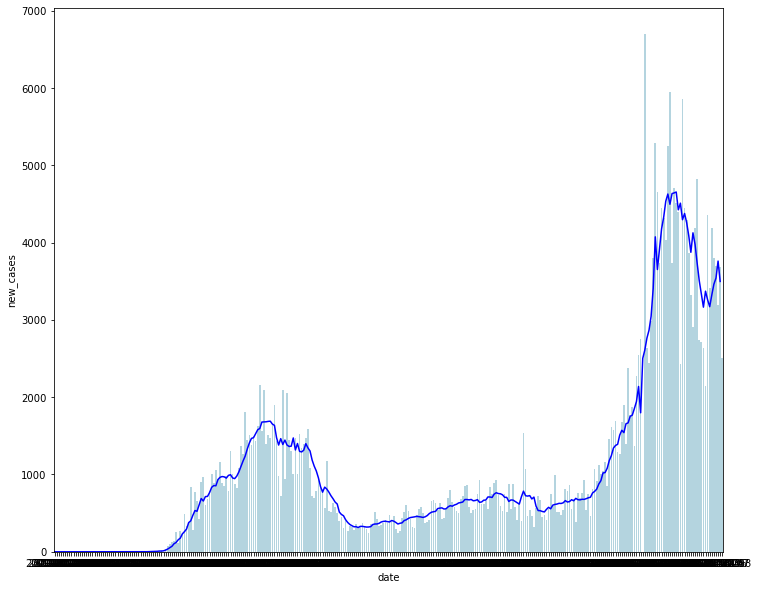

In [59]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
x = cook['date']
y = cook['7-day_avg_new']
y2 = cook['new_cases']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.barplot(x,y2, color = 'lightblue');


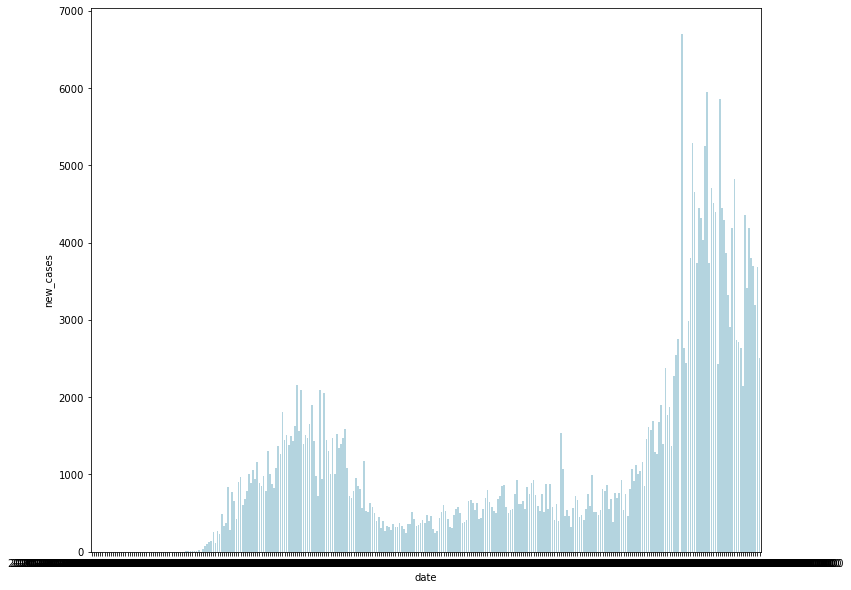

In [60]:
import datetime as dt
import matplotlib.dates as mdates

left = dt.date(2020,1,24)
right = dt.date(2020,10,31)
x = pd.to_datetime(cook['date'])
y = cook['7-day_avg_new']
y2 = cook['new_cases']

fig, ax = plt.subplots(figsize=(12,10))
ax1=sns.lineplot(x,y, color = 'blue')
ax2=sns.barplot(x,y2, color = 'lightblue');

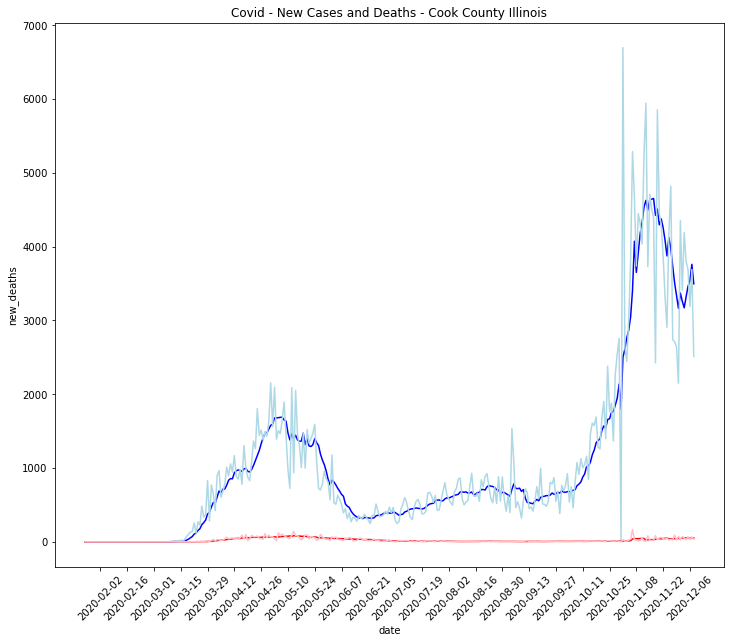

In [61]:
import numpy as np

x = cook['date']
y = cook['7-day_avg_new']
y2 = cook['new_cases']
y3 = cook['7-day_avg_death']
y4 = cook['new_deaths']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.lineplot(x,y2, color = 'lightblue')
sns.lineplot(x,y3, color = 'red')
sns.lineplot(x,y4, color = 'pink');
plt.xticks((np.arange(8, 330, step=14)),rotation=45)
plt.title('Covid - New Cases and Deaths - Cook County Illinois');



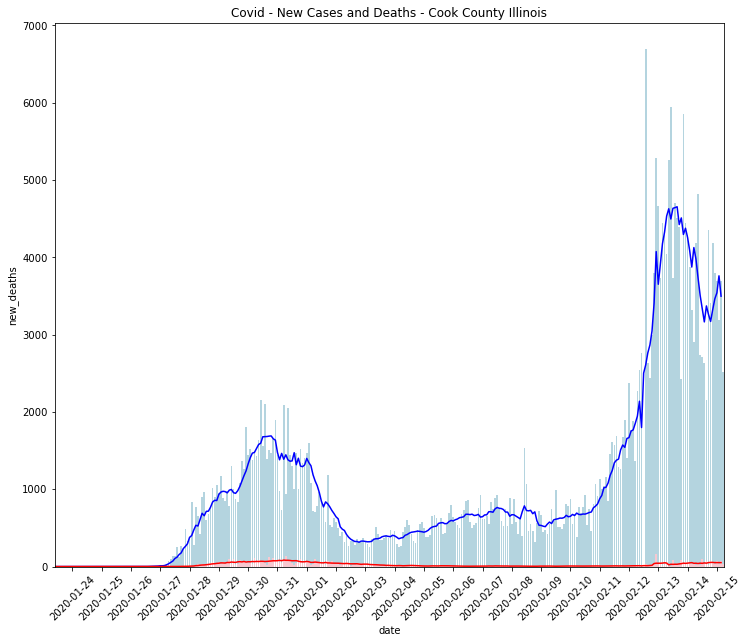

In [62]:
x = cook['date']
y = cook['7-day_avg_new']
y2 = cook['new_cases']
y3 = cook['7-day_avg_death']
y4 = cook['new_deaths']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.barplot(x,y2, color = 'lightblue')
sns.lineplot(x,y3, color = 'red')
sns.barplot(x,y4, color = 'pink');
plt.xticks((np.arange(8, 330, step=14)),rotation=45)
plt.title('Covid - New Cases and Deaths - Cook County Illinois');

In [63]:
illinois = pd.read_sql('''WITH cte as (SELECT date, state, 
                    cases - LAG (cases,1) OVER (PARTITION BY state ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY state ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state)
                    
                    SELECT date, state, new_cases, cumulative_cases,
                    AVG(new_cases) OVER (PARTITION BY state ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_new',
                    new_deaths, cumulative_deaths,
                    AVG(new_deaths) OVER (PARTITION BY state ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_death'
                    FROM cte
                    WHERE state = 'Illinois'
                    ORDER BY date''',conn)
illinois

,date,state,new_cases,cumulative_cases,7-day_avg_new,new_deaths,cumulative_deaths,7-day_avg_death
0,2020-01-24,Illinois,NaN,1,NaN,NaN,0.0,NaN
1,2020-01-25,Illinois,0.0,1,0.000000,0.0,0.0,0.000000
2,2020-01-26,Illinois,0.0,1,0.000000,0.0,0.0,0.000000
3,2020-01-27,Illinois,0.0,1,0.000000,0.0,0.0,0.000000
4,2020-01-28,Illinois,0.0,1,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...
25885,2020-12-08,Illinois,3480.0,4208,409.571429,133.0,145.0,16.571429
25886,2020-12-08,Illinois,39370.0,43578,5569.428571,482.0,627.0,80.285714
25887,2020-12-08,Illinois,-39471.0,4107,481.285714,-534.0,93.0,12.000000
25888,2020-12-08,Illinois,16753.0,20860,2806.000000,210.0,303.0,39.571429


In [64]:
df = pd.read_sql('''SELECT * FROM states WHERE state = 'Illinois' ORDER BY date desc LIMIT 50;''',conn)
df

,date,state,fips,cases,deaths
0,2020-11-29,Illinois,17,721487,12895
1,2020-11-28,Illinois,17,714070,12852
2,2020-11-27,Illinois,17,706123,12705
3,2020-11-26,Illinois,17,698364,12609
4,2020-11-25,Illinois,17,686855,12465
5,2020-11-24,Illinois,17,675543,12294
6,2020-11-23,Illinois,17,665865,12141
7,2020-11-22,Illinois,17,657402,12064
8,2020-11-21,Illinois,17,647474,11967
9,2020-11-20,Illinois,17,635823,11814


In [65]:
illinois = pd.read_sql('''WITH cte as (SELECT date, state, 
                    cases - LAG (cases,1) OVER (PARTITION BY state ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY state ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM states
                    ORDER BY state)
                    
                    SELECT date, state, new_cases, cumulative_cases,
                    AVG(new_cases) OVER (PARTITION BY state ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_new',
                    new_deaths, cumulative_deaths,
                    AVG(new_deaths) OVER (PARTITION BY state ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_death'
                    FROM cte
                    WHERE state = 'Illinois'
                    ORDER BY date''',conn)
illinois

,date,state,new_cases,cumulative_cases,7-day_avg_new,new_deaths,cumulative_deaths,7-day_avg_death
0,2020-01-24,Illinois,NaN,1,NaN,NaN,0,NaN
1,2020-01-25,Illinois,0.0,1,0.000000,0.0,0,0.000000
2,2020-01-26,Illinois,0.0,1,0.000000,0.0,0,0.000000
3,2020-01-27,Illinois,0.0,1,0.000000,0.0,0,0.000000
4,2020-01-28,Illinois,0.0,1,0.000000,0.0,0,0.000000
...,...,...,...,...,...,...,...,...
306,2020-11-25,Illinois,11312.0,686855,11257.000000,171.0,12465,139.571429
307,2020-11-26,Illinois,11509.0,698364,10785.000000,144.0,12609,134.000000
308,2020-11-27,Illinois,7759.0,706123,10042.857143,96.0,12705,127.285714
309,2020-11-28,Illinois,7947.0,714070,9513.714286,147.0,12852,126.428571


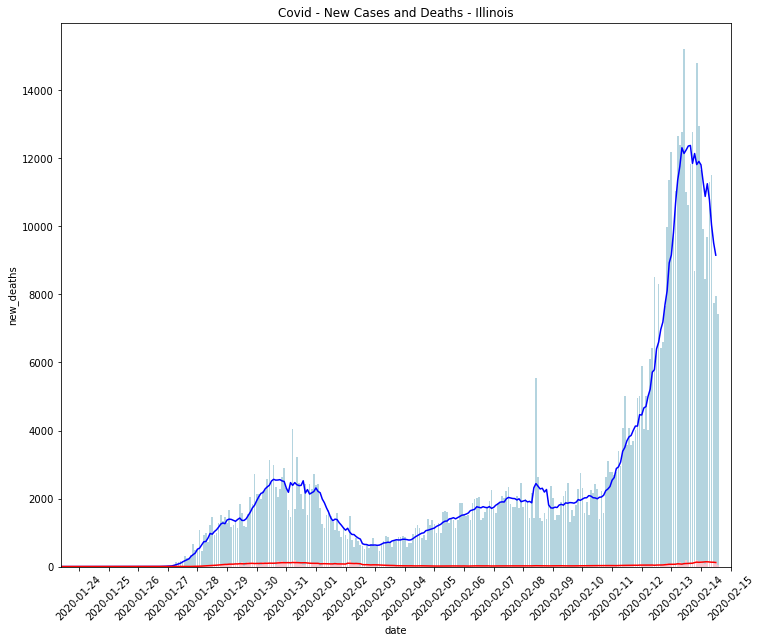

In [66]:
x = illinois['date']
y = illinois['7-day_avg_new']
y2 = illinois['new_cases']
y3 = illinois['7-day_avg_death']
y4 = illinois['new_deaths']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.barplot(x,y2, color = 'lightblue')
sns.lineplot(x,y3, color = 'red')
sns.barplot(x,y4, color = 'pink');
plt.xticks((np.arange(8, 330, step=14)),rotation=45)
plt.title('Covid - New Cases and Deaths - Illinois');

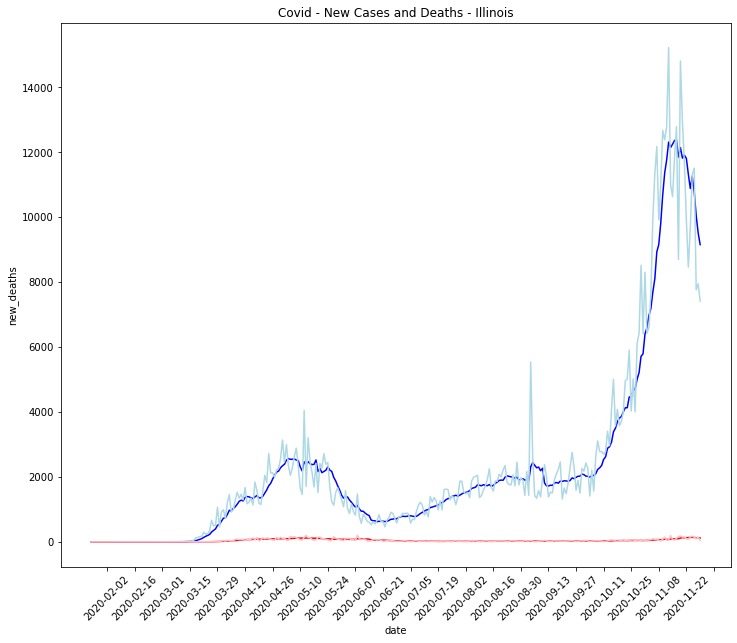

In [67]:
x = illinois['date']
y = illinois['7-day_avg_new']
y2 = illinois['new_cases']
y3 = illinois['7-day_avg_death']
y4 = illinois['new_deaths']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.lineplot(x,y2, color = 'lightblue')
sns.lineplot(x,y3, color = 'red')
sns.lineplot(x,y4, color = 'pink');
plt.xticks((np.arange(8, 330, step=14)),rotation=45)
plt.title('Covid - New Cases and Deaths - Illinois');

In [68]:
il_pop = 12700000

illinois = pd.read_sql('''WITH cte as (SELECT date, state, 
                    cases - LAG (cases,1) OVER (PARTITION BY state ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY state ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM states
                    ORDER BY state)
                    
                    SELECT date, state, new_cases, cumulative_cases, ROUND(cumulative_cases/12700,1) as 'cases_per_million',
                    AVG(new_cases) OVER (PARTITION BY state ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_new',
                    new_deaths, cumulative_deaths,
                    AVG(new_deaths) OVER (PARTITION BY state ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_death'
                    FROM cte
                    WHERE state = 'Illinois'
                    ORDER BY date''',conn)
illinois

,date,state,new_cases,cumulative_cases,cases_per_million,7-day_avg_new,new_deaths,cumulative_deaths,7-day_avg_death
0,2020-01-24,Illinois,NaN,1,0.0,NaN,NaN,0,NaN
1,2020-01-25,Illinois,0.0,1,0.0,0.000000,0.0,0,0.000000
2,2020-01-26,Illinois,0.0,1,0.0,0.000000,0.0,0,0.000000
3,2020-01-27,Illinois,0.0,1,0.0,0.000000,0.0,0,0.000000
4,2020-01-28,Illinois,0.0,1,0.0,0.000000,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...
306,2020-11-25,Illinois,11312.0,686855,54.0,11257.000000,171.0,12465,139.571429
307,2020-11-26,Illinois,11509.0,698364,54.0,10785.000000,144.0,12609,134.000000
308,2020-11-27,Illinois,7759.0,706123,55.0,10042.857143,96.0,12705,127.285714
309,2020-11-28,Illinois,7947.0,714070,56.0,9513.714286,147.0,12852,126.428571


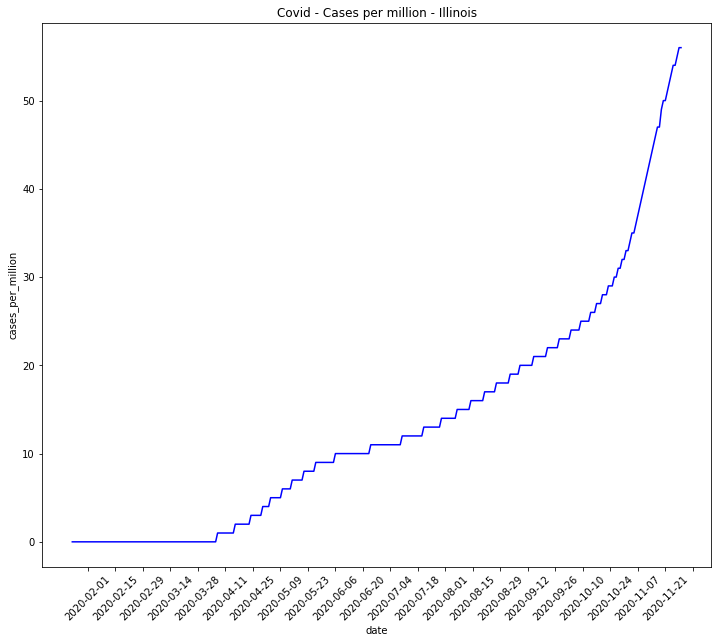

In [69]:
x = illinois['date']
y = illinois['cases_per_million']
# y2 = illinois['new_cases']
# y3 = illinois['7-day_avg_death']
# y4 = illinois['new_deaths']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
# sns.lineplot(x,y2, color = 'lightblue')
# sns.lineplot(x,y3, color = 'red')
# sns.lineplot(x,y4, color = 'pink');
plt.xticks((np.arange(8, 330, step=14)),rotation=45)
plt.title('Covid - Cases per million - Illinois');